In [8]:
using DrWatson
@quickactivate "TriangularHubbard"

using DataStructures
using CodecXz
using SQLite
using DBInterface
using DataFrames
using Printf
using LsqFit
using ProgressMeter
using Quadmath
using Statistics
using ProgressMeter
using JSON
using LinearAlgebra

using PyPlot
using PyCall
mpl = pyimport("matplotlib")
sns = pyimport("seaborn")

  Activating project at `/data/pn1_1/klee/Projects/TriangularHubbard`


PyObject <module 'seaborn' from '/home/klee/.pyenv/versions/conda_jl/lib/python3.7/site-packages/seaborn/__init__.py'>

In [9]:
PyPlot.rc("axes", labelsize="medium", titlesize="medium")
PyPlot.rc("xtick", labelsize="small")
PyPlot.rc("ytick", labelsize="small")
PyPlot.rc("legend", fontsize="x-small")

cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=true)
markers = ["o", "v", "^", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"]
;

In [10]:
n_sites = 12
shape_str = "(2,-2)x(2,4)"
t = 1.0
U = 20.0

20.0

In [11]:
jsondata = open(datadir("lattice-$shape_str.json"), "r") do f
    JSON.parse(read(f, String))
end
shape = hcat(jsondata["shape"]...)
n_sites = Int(det(shape))
bravaiscoordinates = hcat(jsondata["bravais_coordinates"]...)
sitecoordinates = hcat((x["cartesian_coordinates"] for x in jsondata["supercell"]["sites"])...)
momentums = hcat((x["cartesian_coordinates"] for x in jsondata["momentums"])...)
fractionalmomentums = hcat(([eval(Meta.parse(y)) for y in x["fractional_coordinates"]] for x in jsondata["momentums"])...)
sitegroupmap = Dict()
for (i, vs) in enumerate(jsondata["equivalent_site_pairs"])
    for v in vs
        sitegroupmap[v] = i
    end
end
phases = cis.(-2π * momentums' * sitecoordinates)
;

In [12]:
function getrealspacemap(data::AbstractVector)
    realspacemap = fill(NaN, (n_sites, 1))
    for i in 1:n_sites
        realspacemap[i] = data[sitegroupmap[[1,i]]]
    end
    return realspacemap
end

getrealspacemap (generic function with 1 method)

In [13]:
sectors_filepath = datadir("curie", shape_str, "sectors.sqlite3")
isfile(sectors_filepath)

true

In [39]:
conn = DBInterface.connect(SQLite.DB, sectors_filepath)
df = DataFrame(
    DBInterface.execute(conn, """
        SELECT dense_results.idx, nup, ndn, dim, temperature, partition, spin_correlation, energy, energy_squared, -1 as samplecount
        FROM dense_results
        INNER JOIN sectors
        ON dense_results.idx = sectors.idx
        WHERE hopping=? AND interaction=?
        
        UNION
        
        SELECT sparse_results_collection.idx, nup, ndn, dim, temperature, partition, spin_correlation, energy, energy_squared, samplecount
        FROM sparse_results_collection
        INNER JOIN sectors
        ON sparse_results_collection.idx = sectors.idx
        WHERE hopping=? AND interaction=?

    """, (t, U, t, U))
)
# df2 = DataFrame(
#     DBInterface.execute(conn, """
#         SELECT nup, ndn, dim, temperature, partition, spin_correlation, energy, energy_squared, 1 as sparsetype
#         FROM sparse_results_collection
#         INNER JOIN sectors
#         ON sparse_results_collection.idx = sectors.idx
#         WHERE hopping=? AND interaction=?
#     """, (t, U))
# )
DBInterface.close!(conn)

In [40]:
df[:, :Sz] = 0.5*(df[:, :nup] - df[:, :ndn])
df[:, :charge] = df[:, :nup] + df[:, :ndn]
unique(sort(df[:, :Sz]))
# n_list = unique(df[:, :nup] .+ df[:, :ndn])
n_list = n_sites+4:-1:n_sites-5
temperatures = unique(sort(df[:, :temperature]))
;

In [41]:
minimum( df[df[!, :samplecount] .> -1, :samplecount] )

1000

In [42]:
conv(x::AbstractArray) = conv.(x)
function conv(x::AbstractDict)
    if keys(x) == Set(["re", "im"])
        r = conv(x["re"])
        i = conv(x["im"])
        r = isnothing(r) ? NaN : r
        i = isnothing(i) ? NaN : i
        return complex(r, i)
    else
        return Dict(k => conv(v) for (k, v) in x)
    end
end
conv(x::Number) = x
conv(x::AbstractString) = x
conv(x::Nothing) = NaN

conv (generic function with 5 methods)

In [43]:
# szsz = []
# for (irow, row) in enumerate(eachrow(df))
#     push!(szsz, conv(JSON.parse(row[:spin_correlation])))
# end
# df[!, :SzSz] = real.(szsz)

szsz_recover = []
for (irow, row) in enumerate(eachrow(df))
#     push!(szsz_recover, sum( getrealspacemap(conv(JSON.parse(row[:spin_correlation])  ) ./ row[:partition] )) )
    push!(szsz_recover, sum( getrealspacemap(conv(JSON.parse(row[:spin_correlation])  )  )) * n_sites )
end
df[!, :Sz2_recover] = real.(szsz_recover)
;

In [44]:
temperatures = temperatures[0.1 .<= temperatures];

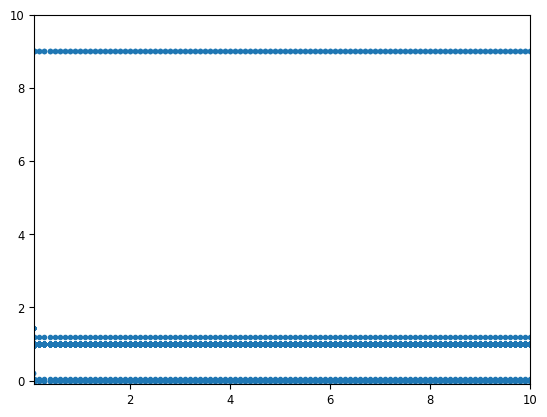

(-0.1, 10.0)

In [45]:
PyPlot.plot(df[:, :temperature], df[:, :Sz2_recover] ./ (df[:, :Sz].^2 .* df[:, :partition]), ".")
PyPlot.xlim(0.1, 10.0)
PyPlot.ylim(-0.1, 10)
# PyPlot.xlabel("Sz^2 * Z")
# PyPlot.ylabel("From Fourier")
# # PyPlot.plot([0,1E306], [0, 1E306 / 12])
# PyPlot.xscale("log")
# PyPlot.yscale("log")

In [47]:
sdf = df[(df[:, :temperature] .> 0.5), :];

In [48]:
@show any(==(Inf), sdf[:, :partition])
@show any(isnan, sdf[:, :partition])
;

any((==)(Inf), sdf[:, :partition]) = false
any(isnan, sdf[:, :partition]) = false


In [49]:
y = sdf[:, :Sz2_recover] ./ (sdf[:, :Sz].^2 .* sdf[:, :partition])
PyPlot.figure(figsize=(4,3))
PyPlot.plot(sdf[:, :temperature], y, ".")


1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4da6ec26d0>

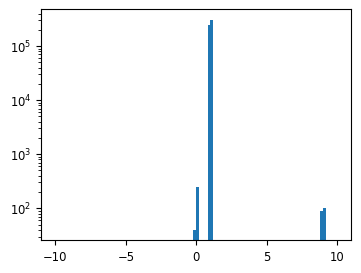

In [50]:
PyPlot.figure(figsize=(4,3))
PyPlot.hist(y, bins=100, range=[-10, 10]);
PyPlot.yscale("log")

In [52]:
PyPlot.figure(figsize=(4,3))
PyPlot.plot(sdf[:, :dim], y, ".")
# PyPlot.xlim(-2, 1001)
# PyPlot.xscale("log")
# PyPlot.xlim(1E-16, nothing)

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4df5aacf90>

In [53]:
names(sdf)

13-element Vector{String}:
 "idx"
 "nup"
 "ndn"
 "dim"
 "temperature"
 "partition"
 "spin_correlation"
 "energy"
 "energy_squared"
 "samplecount"
 "Sz"
 "charge"
 "Sz2_recover"

In [54]:
using CSV

In [57]:
sdf[ .!(isapprox.(sdf[:, :Sz2_recover], (sdf[:, :Sz].^2 .* sdf[:, :partition]); atol=1E-6, rtol=1E-6)), [:idx, :nup, :ndn, :dim, :partition, :Sz, :Sz2_recover]] |> CSV.write("foo.csv")

"foo.csv"

In [61]:
unique( sdf[ .!(isapprox.(sdf[:, :Sz2_recover], (sdf[:, :Sz].^2 .* sdf[:, :partition]); atol=1E-6, rtol=1E-6)), [:idx]] ) |> CSV.write("redo-sectors.csv")

"redo-sectors.csv"

In [ ]:
# It seems that the dense ones are problematic

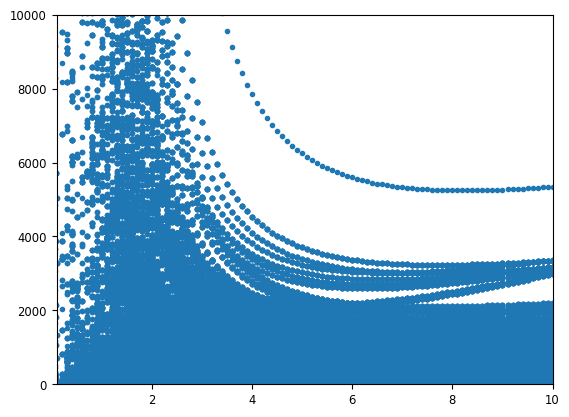

(-0.1, 10000.0)

In [323]:
PyPlot.plot(df[:, :temperature], df[:, :Sz].^2 .* df[:, :partition] - szsz_recover, ".")
PyPlot.xlim(0.1, 10.0)
PyPlot.ylim(-0.1, 10000)
# PyPlot.xlabel("Sz^2 * Z")
# PyPlot.ylabel("From Fourier")
# # PyPlot.plot([0,1E306], [0, 1E306 / 12])
# PyPlot.xscale("log")
# PyPlot.yscale("log")

In [298]:
for (i, (sz1, sz2)) in enumerate(zip(df[:, :Sz].^2, szsz_recover))
    if !isapprox(sz1 * df[i, :partition], sz2 * df[i, :partition])
        print("$i\t$sz1\t$sz2\t")
        println()
    end
end

110	0.25	0.02083333333333333	
111	0.25	0.02083333333333333	
112	0.25	0.0	
113	0.25	0.02083333333333333	
114	0.25	0.02083333333333333	
115	0.25	0.02083333333333333	
116	0.25	0.0	
117	0.25	0.02083333333333333	
118	0.25	0.02083333333333333	
119	0.25	0.02083333333333333	
120	0.25	0.0	
121	0.25	0.02083333333333333	
122	0.25	0.02083333333333333	
123	0.25	0.02083333333333333	
124	0.25	0.0	
125	0.25	0.02083333333333333	
126	0.25	0.02083333333333333	
127	0.25	0.02083333333333333	
128	0.25	0.0	
129	0.25	0.02083333333333333	
130	0.25	0.02083333333333333	
131	0.25	0.02083333333333333	
132	0.25	0.0	
133	0.25	0.02083333333333333	
134	0.25	0.02083333333333333	
135	0.25	0.020833333333333332	
136	0.25	0.0	
137	0.25	0.02083333333333333	
138	0.25	0.02083333333333333	
139	0.25	0.02083333333333333	
140	0.25	0.0	
141	0.25	0.02083333333333333	
142	0.25	0.02083333333333333	
143	0.25	0.02083333333333333	
144	0.25	0.0	
145	0.25	0.02083333333333333	
146	0.25	0.020833333333333332	
147	0.25	0.02083333333333333	
14

Excessive output truncated after 524315 bytes.

17961	16.0	1.333333333333333	
17962	16.0	1.333333333333333	
17963	16.0	1.3333333333333328	
17964	16.0	1.3333333333333335	
17965	16.0	1.3333333333333337	
17966	16.0	1.3333333333333335	
17967	16.0	1.3333333333333335	
17968	16.0	1.333333333333333	
17969	16.0	1.333333333333333	
17970	16.0	1.3333333333333328	
17971	16.0	1.3333333333333335	
17972	16.0	1.3333333333333335	
17973	16.0	1.3333333333333335	
17974	16.0	1.3333333333333335	
17975	16.0	1.333333333333333	
17976	16.0	1.333333333333333	
17977	16.0	1.3333333333333328	
17978	16.0	1.3333333333333335	
17979	16.0	1.3333333333333335	
17980	16.0	1.3333333333333335	
17981	16.0	1.3333333333333335	
17982	16.0	1.3333333333333328	
17983	16.0	1.3333333333333333	
17984	16.0	1.3333333333333328	
17985	16.0	1.3333333333333335	
17986	16.0	1.333333333333333	
17987	16.0	1.3333333333333328	
17988	16.0	1.3333333333333333	
17989	16.0	1.3333333333333333	
17990	16.0	1.3333333333333335	
17991	16.0	1.3333333333333328	
17992	16.0	1.3333333333333333	
17993	16.0	1.33

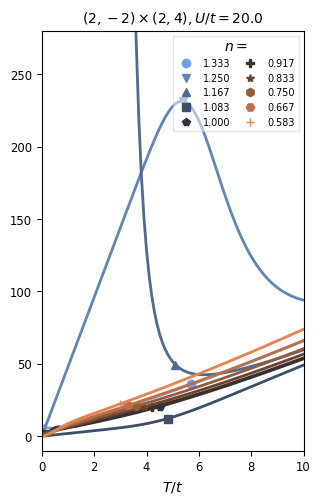

PyObject Text(0.5, 1.0, '$(2,-2)\\times(2,4), U/t=20.0$')

In [241]:
# Plot q=0 susceptibility

fig = PyPlot.figure(figsize=(3.4, 5))
fig.subplots_adjust(left=0.18, right=0.95, top=0.94, bottom=0.1)
ax = fig.gca()

ymax = 0.0

for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :charge] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / (n_sites * T)
        Sz_avg = 0
        if !isnan(corr)
            push!(xs, T)
            push!(ys, corr - Sz_avg^2 / (n_sites * T))
        end
    end
    ys = 1 ./ ys
    
    color=cmap((idx-1) / (length(n_list)-1))
    ax.plot(
        xs,
        ys,
        linestyle="-",
        linewidth=2,
        color=color,
        alpha=1.0,
    )
    let
        xmark = xs[60 - 3*idx]
        ymark = ys[60 - 3*idx]
        ax.plot(xmark, ymark, linestyle="None", marker=markers[idx], label=(@sprintf "%.3f" (n/n_sites)),
            color=color,
            alpha=1.0, markersize=6
        )
    end
#     ax.plot([0, 1], [yoffset, yoffset], linestyle="--", linewidth=1, color=color, zorder=-3)
    ymax = max(ymax, maximum(ys))
end
ax.set_xlim(0, maximum(temperatures))
# ax.set_ylim(0, 1)
ax.set_ylim(-10, 280)
# ax.set_ylim(0, 150)


ax.legend(title=raw"$n=$", ncol=2, loc=1, framealpha=0.5, columnspacing=1)
ax.set_xlabel(raw"$T/t$")
# ax.set_ylabel(raw"$1/\chi_{zz}$")

ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), U/t=$(U/t)\$")

# fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).png", dpi=300)
# fig.savefig("triangular-hubbard_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300)


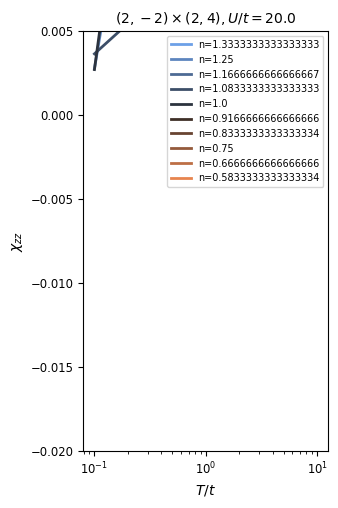

PyObject <matplotlib.legend.Legend object at 0x7feee5bde990>

In [238]:
fig = PyPlot.figure(figsize=(7, 5))
fig.subplots_adjust(left=0.18, right=0.95, top=0.94, bottom=0.1)

ax = fig.add_subplot(1,2,1)

for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = sum(ssdf[:, :energy_squared]) / sum(ssdf[:, :partition]) / (n_sites * T)
        Sz_avg = sum(ssdf[:, :energy]) / sum(ssdf[:, :partition])
        if !isnan(corr)
            push!(xs, T)
            push!(ys, corr - Sz_avg^2 / (n_sites * T))
        end
    end

    color=cmap((idx-1) / (length(n_list)-1))
    ax.plot(
        xs,
        ys,
        linestyle="-",
        linewidth=2,
        color=color,
        alpha=1.0,
        label="n=$(n/n_sites)",
    )
end
ax.set_xlabel(raw"$T/t$")
ax.set_ylabel(raw"$\chi_{zz}$")
# ax.set_ylim(-0.002, 0.002)
# ax.set_xlim(0, nothing)
# ax.set_xlim(0, 0.5)
# ax.set_ylim()
ax.set_ylim(-0.02, 0.005)
ax.set_xscale("log")
ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), U/t=$(U/t)\$")
ax.legend()

684956×11 DataFrame
    Row │ nup    ndn    temperature  partition  spin_correlation               ⋯
        │ Int64  Int64  Float64      Float64    String                         ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │     0      0         0.01     1.0     [0.0,0.0,0.0,0.0]              ⋯
      2 │     0      0         0.02     1.0     [0.0,0.0,0.0,0.0]
      3 │     0      0         0.03     1.0     [0.0,0.0,0.0,0.0]
      4 │     0      0         0.04     1.0     [0.0,0.0,0.0,0.0]
      5 │     0      0         0.05     1.0     [0.0,0.0,0.0,0.0]              ⋯
      6 │     0      0         0.06     1.0     [0.0,0.0,0.0,0.0]
      7 │     0      0         0.07     1.0     [0.0,0.0,0.0,0.0]
      8 │     0      0         0.08     1.0     [0.0,0.0,0.0,0.0]
      9 │     0      0         0.09     1.0     [0.0,0.0,0.0,0.0]              ⋯
     10 │     0      0         0.1      1.0     [0.0,0.0,0.0,0.0]
     11 │     0      0         0.2      1.0     [0.0,0.0,0.0,0.0]
   ⋮    │   ⋮      ⋮         ⋮           ⋮                      ⋮              ⋱
 684947 │     7      7         9.1     22.2348  [4.021713046933371,-0.37324492
 684948 │     7      7         9.2     23.6015  [4.258550951884088,-0.39509353 ⋯
 684949 │     7      7         9.3     25.027   [4.504859994178967,-0.41780883
 684950 │     7      7         9.4     26.5124  [4.7608139499046125,-0.4414065
 684951 │     7      7         9.5     28.0592  [5.026583477074494,-0.46590192
 684952 │     7      7         9.6     29.6685  [5.302336010385936,-0.49131018 ⋯
 684953 │     7      7         9.7     31.3416  [5.588235662882506,-0.51764608
 684954 │     7      7         9.8     33.0798  [5.884443134442332,-0.54492409
 684955 │     7      7         9.9     34.8842  [6.191115626998357,-0.57315837
 684956 │     7      7        10.0     36.756   [6.508406766383743,-0.60236276 ⋯
                                               7 columns and 684935 rows omitted

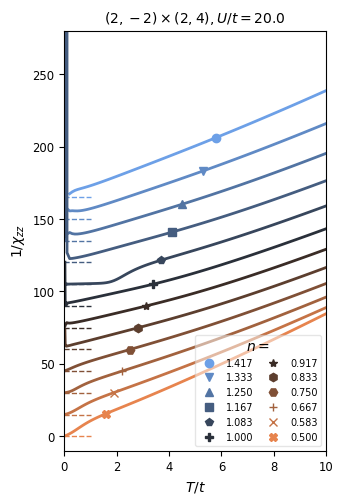

In [13]:
fig = PyPlot.figure(figsize=(3.4, 5))
fig.subplots_adjust(left=0.18, right=0.95, top=0.94, bottom=0.1)
ax = fig.gca()

ymax = 0.0
yoffsets = [15 * (length(n_list) - idx) for idx in 1:length(n_list)]
yoffsets[1:end-1] .+= 0
yoffsets[1:end-2] .+= 0

for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / (n_sites * T)
    #     Sz_avg = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz])) / sum(ssdf[:, :partition]))
        Sz_avg = 0
        if !isnan(corr)
            push!(xs, T)
            push!(ys, corr - Sz_avg^2 / (n_sites * T))
        end
    end
    ys = 1 ./ ys
    yoffset = yoffsets[idx]

    color=cmap((idx-1) / (length(n_list)-1))
    ax.plot(
        xs,
        ys .+ yoffset,
        linestyle="-",
        linewidth=2,
        color=color,
        alpha=1.0,
    )
    let
        xmark = xs[60 - 3*idx]
        ymark = ys[60 - 3*idx] + yoffset
        ax.plot(xmark, ymark, linestyle="None", marker=markers[idx], label=(@sprintf "%.3f" (n/n_sites)),
            color=color,
            alpha=1.0, markersize=6
        )
    end
    ax.plot([0, 1], [yoffset, yoffset], linestyle="--", linewidth=1, color=color, zorder=-3)
    ymax = max(ymax, maximum(ys))
end
ax.set_xlim(0, maximum(temperatures))
ax.set_ylim(-10, 280)

ax.legend(title=raw"$n=$", ncol=2, loc=4, framealpha=0.5, columnspacing=1)
ax.set_xlabel(raw"$T/t$")
ax.set_ylabel(raw"$1/\chi_{zz}$")

ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), U/t=$(U/t)\$")

fig.savefig("triangular-hubbard-invsusc_$(shape_str)_t=$(t)_U=$(U).png", dpi=300)
fig.savefig("triangular-hubbard-invsusc_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300)


In [15]:
@. model(x, p) = (x - p[2]) / p[1]
temperatures = unique(sort(df[:, :temperature]))
fit_temperatures = [T for T in temperatures if 0.7 <= T <= 5.5]

49-element Vector{Float64}:
 0.7
 0.8
 0.9
 1.0
 1.1
 1.2
 1.3
 1.4
 1.5
 1.6
 1.7
 1.8
 1.9
 ⋮
 4.4
 4.5
 4.6
 4.7
 4.8
 4.9
 5.0
 5.1
 5.2
 5.3
 5.4
 5.5

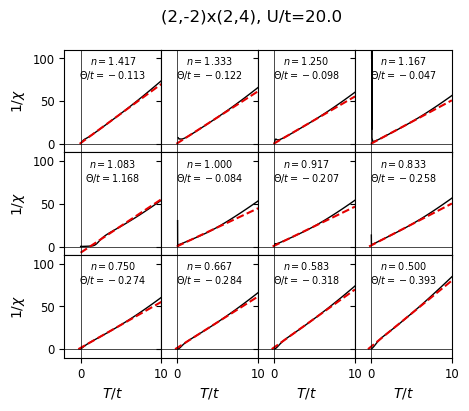

In [16]:
fig = PyPlot.figure(figsize=(5, 4))
axs = fig.subplots(3, 4, sharex=true, sharey=true)
axs = [axs[i,j] for i in 1:3 for j in 1:4]

fig.subplots_adjust(hspace=0, wspace=0)

axs[9].set_xlabel(raw"$T/t$")
axs[10].set_xlabel(raw"$T/t$")
axs[11].set_xlabel(raw"$T/t$")
axs[12].set_xlabel(raw"$T/t$")

axs[1].set_ylabel(raw"$1/\chi$")
axs[5].set_ylabel(raw"$1/\chi$")
axs[9].set_ylabel(raw"$1/\chi$")

fit_params = []
for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / T
        if !isnan(corr)
            push!(xs, T)
            push!(ys, n_sites / corr)
        end
    end

    xs_fit, ys_fit = let i = (0.8 .<= xs .<= 5.5)
        xs[i], ys[i]
    end
    f = curve_fit(model, xs_fit, ys_fit, [1.0, 0.0])
    ax = axs[idx]
    # ax = fig.add_subplot(3, 4, idx, sharex=ax0, sharey=ax0)
    ax.plot(xs, ys, linewidth=1, color="black")
    xfit = [min(f.param[2], 0.0), maximum(xs)] 
    # ax.plot([f.param[2], maximum(xs)], model([f.param[2], maximum(xs)], f.param), linestyle="--", color="xkcd:red")
    ax.plot(xfit, model(xfit, f.param), linestyle="--", color="xkcd:red")

    ax.set_ylim(-10, 110)
    ax.set_xlim(-2, 10)
    ax.text(0.5, 0.95, (@sprintf "\$n=%.3f\$\n\$\\Theta/t=%.3f\$" (n/n_sites) (f.param[2])), ha="center", va="top", transform=ax.transAxes, fontsize="x-small")
#     ax.text(0.5, 0.95, (@sprintf "n=%.3f" (n/n_sites)), ha="center", va="top", transform=ax.transAxes, fontsize="small")
#     ax.set_title("n=$n")
    ax.axhline(0, linewidth=0.5, color="black")
    ax.axvline(0, linewidth=0.5, color="black")
    #ax.set_xscale("log")
    push!(fit_params, [n, f.param[2]] )
end
fit_params = hcat(fit_params...)
fig.suptitle("$(shape_str), U/t=$(U/t)")
fig.savefig("triangular-hubbard-curie-weiss-fits_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300, bbox_inches="tight")
fig.savefig("triangular-hubbard-curie-weiss-fits_$(shape_str)_t=$(t)_U=$(U).png", dpi=300, bbox_inches="tight")


In [21]:
fit_params = []
# for (idx, n) in enumerate(n_list)
for (idx, n) in enumerate(2:2*n_sites-2)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / T
        if !isnan(corr)
            push!(xs, T)
            push!(ys, n_sites / corr)
        end
    end

    xs_fit, ys_fit = let i = (0.8 .<= xs .<= 5.5)
        xs[i], ys[i]
    end
    f = curve_fit(model, xs_fit, ys_fit, [1.0, 0.0])
    push!(fit_params, [n, f.param[2]] )
end
fit_params = hcat(fit_params...)

2×21 Matrix{Float64}:
  2.0       3.0      4.0        5.0       …  21.0          22.0
 -4.88996  -1.2294  -0.750094  -0.523503      0.000669563   0.00458997

In [27]:
fig = PyPlot.figure(figsize=(3.5, 3))
ax = fig.gca()
ax2 = ax.twinx()
xs = fit_params[1, :] ./ n_sites
ys = -fit_params[2, :]
ax.plot(xs, ys, "o-" , color="black", linewidth=0.5)
ax.axhline(0, linewidth=0.5, color="black", zorder=-10)

ymin, ymax = minimum(ys)-0.1, maximum(ys) + 0.1
ax.set_xlim(0.4, 1.6)
ymin = -1.6
ymax = 1.0
ax.set_ylim(ymin, ymax)
ax2.set_ylim(ymin * 8.7, ymax*8.7)
ax.set_title("$shape_str, \$U/t=$(U/t)\$")
ax.set_xlabel(raw"$n$")
ax.set_ylabel(raw"$-\theta/t$")
ax2.set_ylabel(raw"$-\theta\,\mathrm{(K)}$")
fig.savefig("weisstemp-$(shape_str)_fit_to_jieshan.png", dpi=300, bbox_inches="tight")
fig.savefig("weisstemp-$(shape_str)_fit_to_jieshan.pdf", dpi=300, bbox_inches="tight")


In [ ]:
fig = PyPlot.figure(figsize=(5, 4))
axs = fig.subplots(3, 4, sharex=true, sharey=true)
axs = [axs[i,j] for i in 1:3 for j in 1:4]

fig.subplots_adjust(hspace=0, wspace=0)

axs[9].set_xlabel(raw"$T/t$")
axs[10].set_xlabel(raw"$T/t$")
axs[11].set_xlabel(raw"$T/t$")
axs[12].set_xlabel(raw"$T/t$")

axs[1].set_ylabel(raw"$1/\chi$")
axs[5].set_ylabel(raw"$1/\chi$")
axs[9].set_ylabel(raw"$1/\chi$")

fit_params = []
for (idx, n) in enumerate(n_list)
    xs = Float64[]
    ys = Float64[]
    sdf = df[df[:, :nup] .+ df[:, :ndn] .== n, :]
    for T in temperatures
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        if isempty(ssdf)
            continue
        end
        corr = (sum(ssdf[:, :partition] .* (ssdf[:, :Sz].^2)) / sum(ssdf[:, :partition])) / T
        if !isnan(corr)
            push!(xs, T)
            push!(ys, n_sites / corr)
        end
    end

    xs_fit, ys_fit = let i = (5 .<= xs)
        xs[i], ys[i]
    end
    f = curve_fit(model, xs_fit, ys_fit, [1.0, 0.0])
    ax = axs[idx]
    # ax = fig.add_subplot(3, 4, idx, sharex=ax0, sharey=ax0)
    ax.plot(xs, ys, linewidth=1, color="black")
    xfit = [min(f.param[2], 0.0), maximum(xs)] 
    # ax.plot([f.param[2], maximum(xs)], model([f.param[2], maximum(xs)], f.param), linestyle="--", color="xkcd:red")
    ax.plot(xfit, model(xfit, f.param), linestyle="--", color="xkcd:red")

    ax.set_ylim(-10, 120)
    ax.set_xlim(-2, 10)
    ax.text(0.5, 0.95, (@sprintf "\$n=%.3f\$\n\$\\Theta/t=%.3f\$" (n/n_sites) (f.param[2])), ha="center", va="top", transform=ax.transAxes, fontsize="x-small")
#     ax.text(0.5, 0.95, (@sprintf "n=%.3f" (n/n_sites)), ha="center", va="top", transform=ax.transAxes, fontsize="small")
#     ax.set_title("n=$n")
    ax.axhline(0, linewidth=0.5, color="black")
    ax.axvline(0, linewidth=0.5, color="black")
    #ax.set_xscale("log")
    push!(fit_params, [n, f.param[2]] )
end
fit_params = hcat(fit_params...)
fig.suptitle("$(shape_str), U/t=$(U/t)")
# fig.savefig("triangular-hubbard-curie-weiss-fits_$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300, bbox_inches="tight")
# fig.savefig("triangular-hubbard-curie-weiss-fits_$(shape_str)_t=$(t)_U=$(U).png", dpi=300, bbox_inches="tight")


In [ ]:
fig = PyPlot.figure(figsize=(3.5, 3))
ax = fig.gca()
ax2 = ax.twinx()
xs = fit_params[1, :] ./ n_sites
ys = -fit_params[2, :]
ax.plot(xs, ys, "o-")
ax.axhline(0, linewidth=0.5, color="black", zorder=-10)

ymin, ymax = minimum(ys)-0.1, maximum(ys) + 0.1
ax.set_ylim(ymin, ymax)
ax2.set_ylim(ymin * 8.7, ymax*8.7)
ax.set_title("$shape_str, \$t=1, U=20\$")
ax.set_xlabel(raw"$n$")
ax.set_ylabel(raw"$-\theta/t$")
ax2.set_ylabel(raw"$-\theta\,\mathrm{(K)}$")
# fig.savefig("weiss-$(shape_str)_fit_to_jieshan.png", dpi=300, bbox_inches="tight")
# fig.savefig("weiss-$(shape_str)_fit_to_jieshan.pdf", dpi=300, bbox_inches="tight")


## Plot Charge

In [277]:
# Plot Charge susceptibility
sdf = df
chemical_potentials = -20:0.1:40
Qg = zeros(Float64, (length(temperatures), length(chemical_potentials)))
χg = zeros(Float64, (length(temperatures), length(chemical_potentials)))
Tg = zeros(Float64, (length(temperatures), length(chemical_potentials)))
μg = zeros(Float64, (length(temperatures), length(chemical_potentials)))
@showprogress for (imu, mu) in enumerate(chemical_potentials)
    for (iT, T) in enumerate(temperatures)
        ssdf = sdf[sdf[:, :temperature] .== T, :]
        z_ = Float128.(ssdf[:, :partition])
        q_ = Float128.(ssdf[:, :charge])
        T_ = Float128(T)
        mu_ = Float128(mu)
        emu_ = exp.(mu_ .* q_ / T_)
        qavg_ = sum(q_ .* z_ .* emu_) ./ sum(z_ .* emu_)
        q2avg_ = sum( q_ .* q_ .* z_ .* emu_) ./ sum(z_ .* emu_)
        Qg[iT, imu] = qavg_
        χg[iT, imu] = (q2avg_ - qavg_.^2) ./ (n_sites * T_)
        Tg[iT, imu] = T
        μg[iT, imu] = mu
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:55


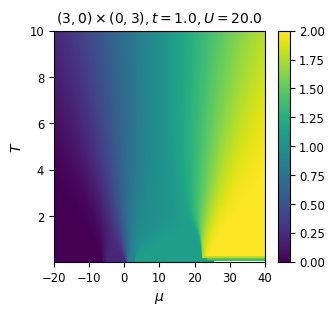

In [333]:
fig = PyPlot.figure(figsize=(3.4, 3))
ax = fig.gca()
# img = ax.imshow(result, extent=[minimum(chemical_potentials), maximum(chemical_potentials), minimum(temperatures), maximum(temperatures)],
# aspect="auto", interpolation="None")
img = ax.pcolor(μg, Tg, Qg ./ n_sites, vmin=0, vmax=2)
ax.set_xlabel(raw"$\mu$")
ax.set_ylabel(raw"$T$")
ax.set_title("\$$(replace(shape_str, "x"=>"\\times")), t=$t, U=$U\$")

fig.colorbar(mappable=img)
# fig.savefig("triangular-hubbard-charge-$(shape_str)_t=$(t)_U=$(U).png", dpi=300)
fig.savefig("triangular-hubbard-charge-$(shape_str)_t=$(t)_U=$(U).pdf", dpi=300, bbox_inches="tight")


In [281]:
χg[isnan.(χg)] .= 0
χg[abs.(χg) .< 1E-8] .= 0
;

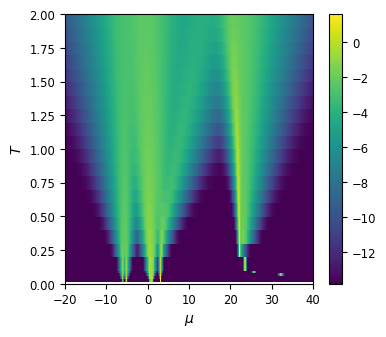

(0.0, 2.0)

In [282]:
fig = PyPlot.figure(figsize=(4, 3.5))
ax = fig.gca()
# img = ax.imshow(result, extent=[minimum(chemical_potentials), maximum(chemical_potentials), minimum(temperatures), maximum(temperatures)],
# aspect="auto", interpolation="None")
img = ax.pcolor(μg, Tg, log.(χg .+ 1E-6))
ax.set_xlabel(raw"$\mu$")
ax.set_ylabel(raw"$T$")
fig.colorbar(mappable=img)
ax.set_ylim(0, 2)

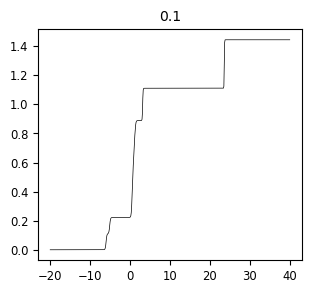

PyObject Text(0.5, 1.0, '0.1')

In [341]:
# for i in 1:size(μg, 1)
fig = PyPlot.figure(figsize=(3.4, 3))
let i = 5
    PyPlot.plot(μg[i, :], Qg[i, :] ./ n_sites, linewidth=0.5, color="black")
    PyPlot.title("$(Tg[i, 1])")
end

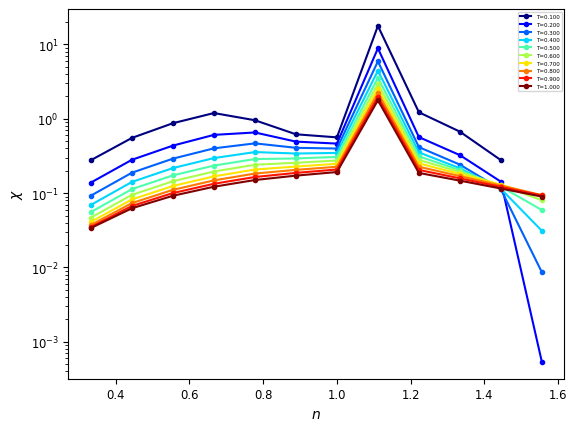